## Diaries of a model export
As machine learning practitionners, our workflow is pretty much the same everytime : 
- Get the data 
- Decide on an architecture
- Write the training pipeline
- Evaluate it
- It's good
- **Throw the whole thing in the trash and jump to the next project**

All good so far. 
However, it turns out that sometimes, OTHER PEOPLE actually want to use our models (scary, I know)

Then come a whole plethora of requirements : 
- Make the model platform-agnostic
- Require minimal model-specific knowledge from the user
- Keep inference time low
- Insure consistency of model parameters and processing steps

We're going to see here how to allow users to run inference on our models, using onnx : https://github.com/onnx/onnx/tree/main

## INTRODUCTION
Let's take as an example the SAM-Med3D model, as described here : https://github.com/uni-medical/SAM-Med3D

## SETUP
Lets import a few libraries and explore the data

In [1]:
import os
import sys
import glob
import yaml
import numpy as np
from image_manipulation import save_volume_viz

# a config file with paths to the models and data
config = yaml.safe_load(open("model_inference/config.yaml"))

['imgs', 'gts', 'spacing']
(76, 512, 512)
[0 1 2 3 4 5]


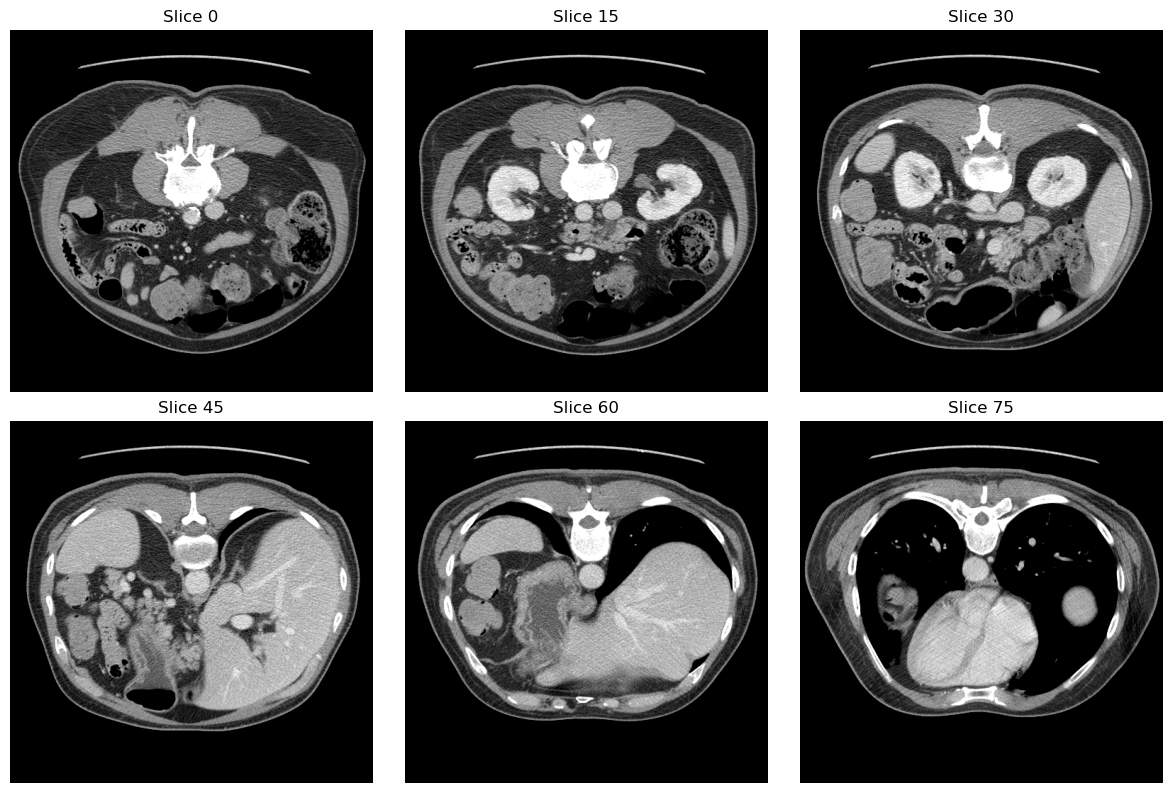

In [2]:
npz_file = glob.glob(os.path.join(config["VAL_DIR"],"*.npz"))[0]
data = np.load(npz_file, allow_pickle=True)
print(list(data.keys())) # ['imgs', 'gts', 'spacing']
print(data["imgs"].shape) # (76, 512, 512)
img = data["imgs"]
mask_gt = data["gts"]
print(np.unique(mask_gt)) #[0 1 2 3 4 5] : ground truth labels
save_volume_viz(img,save_path=None,slice_indices=(6, 'uniform'), show =True)

In [4]:
import medim

ckpt_path = config["SAM_CKPT_PATH"]
model = medim.create_model("SAM-Med3D",
                            pretrained=True,
                            checkpoint_path=ckpt_path)

creating model SAM-Med3D
try to load pretrained weights from /nfs/norasys/notebooks/camaret/SAM-Med3D/ckpt/sam_med3d_turbo_bbox_cvpr.pth


RuntimeError: Error(s) in loading state_dict for SAM_Med3D:
	Unexpected key(s) in state_dict: "prompt_encoder.point_embeddings.2.weight", "prompt_encoder.point_embeddings.3.weight". 

3. Background: SAM-Med3D and ONNX

    SAM-Med3D:

        What is it? (Interactive 3D medical image segmentation model based on SAM).

        High-level architecture (Image Encoder, Prompt Encoder, Mask Decoder). Briefly describe the role of each.

        Inputs: Image volume, Prompts (points w/ labels, optional masks/boxes).

        Outputs: Segmentation mask (low-resolution + IoU prediction).

        Link to paper/repo if applicable.

    ONNX (Open Neural Network Exchange):

        What is it? (An open format for representing ML models).

        Why use it? (Interoperability between frameworks - PyTorch, TensorFlow, ONNX Runtime; Hardware acceleration optimization; Deployment simplification).

4. The Export Process: Strategy and Initial Attempt

    Strategy: Explain the initial plan was likely to export the three main components separately.

    Core Tool: torch.onnx.export: Briefly introduce the function and its key arguments (model, args, f, opset_version, input_names, output_names, dynamic_axes).

    Loading the PyTorch Model: Show the code using medim.create_model.

    (Conceptual) Component Export: Describe conceptually how you'd export each part (Image Encoder, Prompt Encoder, Mask Decoder) with dummy inputs matching their expected shapes. Maybe show a snippet of the image encoder export as it was the first step and worked relatively easily after fixing the input shape.

5. Challenges and Troubleshooting (The Core Story)

    Goal: Explain that direct export often reveals incompatibilities. Detail the specific issues faced sequentially.

    Challenge 1: Image Encoder Input Shape Mismatch

        Problem: Describe the initial attempt using a potentially incorrect dummy input size (e.g., 64x64x64).

        Error: Show the The size of tensor a (4) must match the size of tensor b (8)... error message (use markdown blockquote).

        Analysis: Explain this likely relates to downsampling ratios in the ViT encoder expecting a standard input size (e.g., 128x128x128).

        Solution: Show the code change setting dummy_roi_image_shape = (1, 1, 128, 128, 128).

    Challenge 2: Prompt Encoder Broadcasting Issues (Where Node)

        Problem: Describe exporting the prompt encoder and encountering runtime errors during validation.

        Error 1 (Broadcasting): Show the Attempting to broadcast an axis by a dimension other than 1. 2 by 384 error.

        Analysis 1: Hypothesize it's related to label broadcasting. Show the unsqueeze(-1) attempt on labels.

        Error 2 (Rank Mismatch): Show the Invalid rank for input: point_labels Got: 3 Expected: 2 error.

        Analysis 2: Explain the contradictory errors suggest a deeper issue with how label-based selection translates to ONNX, likely involving the ONNX Where operator's limitations. Mention trying different opset versions (opset_version=13 etc.) didn't resolve the core issue. Mention trying the simple wrapper didn't fix it either.

    Challenge 3: Dynamo Exporter Issues (If applicable)

        Problem: Mention that using dynamo=True (the newer PyTorch exporter) also didn't resolve the prompt encoder issue and sometimes introduces its own complexities or different error messages (like the final Can broadcast 0 by 0 or 1. 2 is invalid error).

        Solution: Note that disabling Dynamo (dynamo=False) was necessary to revert to the standard exporter for reliable results in this case.

6. The Key Solution: Modifying the Prompt Encoder

    Deep Dive: Explain that the root cause was identified in the _embed_points method's use of boolean indexing and in-place operations (point_embedding[labels == k] += ...).

    Why it Fails ONNX: Explain why this pattern is problematic for ONNX graph generation (difficulty mapping to static operations like Where or ScatterND while respecting broadcasting rules).

    The Fix: Using torch.where:

        Show the original problematic lines from _embed_points.

        Show the modified code using sequential torch.where calls to select and combine the base PE and the type embeddings.

        Explain how torch.where maps more directly and reliably to the ONNX Where operator.

    Integration: Show the code snippet for replacing the original prompt encoder in the loaded PyTorch model with an instance of the PromptEncoder3DModified class before export. Include the load_state_dict step.

7. Exporting a Single Combined ONNX Model

    Motivation: Explain why a single file is often preferable (simpler deployment, PE handled internally).

    The Wrapper Approach:

        Show the SamMed3dOnnxModel wrapper class definition.

        Explain how its forward method orchestrates the calls to the three components (image_encoder, modified prompt_encoder, mask_decoder) and includes the get_dense_pe() call.

    Final Export Call: Show the single torch.onnx.export call using the SamMed3dOnnxModel instance, the combined dummy inputs, and the correct input/output names.

8. Validation: Running Inference with the Combined ONNX Model

    Goal: Show how to use the exported sam_med3d_combined.onnx file.

    Loading the ONNX Model: Show code using onnxruntime.InferenceSession.

    Preparing Inputs:

        Load sample data (.npz).

        Run data_preprocess (emphasize matching the expected input size, e.g., 128³).

        Prepare points_coords, points_labels (stress dtype=torch.int64 for labels!), and mask_input.

        Convert inputs to NumPy arrays.

        Create the input dictionary with keys matching the input_names from export.

    Running Inference: Show the ort_session.run() call with the input dictionary and output names.

    Post-processing: Show how to take the low_res_masks_onnx output, convert to Torch, interpolate, apply sigmoid, threshold, and use data_postprocess to map back to the original image space.

    (Optional but recommended) Visualization: Include code to save a visualization of the final predicted mask using save_volume_viz.

9. Conclusion and Key Takeaways

    Summary: Briefly recap the successful export of SAM-Med3D to a single ONNX file.

    Learnings:

        ONNX export often requires model adjustments beyond simple API calls.

        Advanced indexing/in-place operations in PyTorch can be problematic for ONNX. torch.where is often a good alternative.

        Debugging ONNX export involves iterative steps: checking shapes, trying different opsets, analysing runtime errors, and potentially modifying model code.

        Wrapper modules are useful for managing export complexity (handling keyword args or combining models).

        Understanding the model's internal data flow is crucial.

    Next Steps (Optional): Suggest potential further steps (performance benchmarking ONNX vs PyTorch, deploying the ONNX model).